# Guass-Newton Algorithm

**Difinition**\
**Guass-Newton Algorithm** is used to solve **non-linear least squares** problem, which is equivalent to minimizing a sum of squared function values. It is an extansion of **Newton's method** for finding a minimum of a non-linear function.

**Non-linear Least Squares Problem**
In this problem, we want to minimize the objective function $f(x)$, which is the sum of squared residuals:
$$f(x) = \sum_{i=1}^n r_i(x)^2$$
where $r_i(x)$ are residuals. It is the difference between the observed and predicted data.

The algorithm for solving the Guass-Newton method can be written as follows:
1. Set the initial value of $x_0$
2. For each iteration $k$, Compute the residual vector $r(x_k)$, and calculate the Jacobian $J(x_k)$ at $x_k$
3. Solve the Guass-Newton equation $H\Delta x_k = g$, where:
    - $H$ is the Hessian approximation $J(x_k)^TJ(x_k)$
    - $g$ is the gradient $-J(x_k)^Tr(x_k)$
    In this case, we can solve for $\Delta x_k$ where:
    $$\Delta x_k = -(J(x_k)^TJ(x_k))^{-1}J(x_k)^Tr(x_k)$$
4. Update $x_{k+1} = x_k + \Delta x_k$ and go to second step
5. Stop if $\Delta x_k$ is small enough (< tolerance), or stop the algorithm if convergence is achieved otherwise continue

# Iterative Closest Point (ICP) Algorithm

i**Iterative closest point** is an algorithm used to minimize the difference between two points clouds. It is works by keep one point cloud as the reference or target (fixed), while try to transform the other (other source) in order to match the reference.

The transformation (combination of translation $t$ and rotation $R$) is estimated in order to minimize an erro metric which is the sum of squared differences between the coordinates of the matched pairs.

- **Input:** 
    - $P$ source point cloud for all point $p_i \in P$
    - $Q$ target point cloud for all point $q_j \in Q$
    - MaxIterations: Maximum number of iterations
    - Tolerance: Convergence tolerance for stopping criteria
    
- **Ouput:**
    - $R$ Optimal rotation matrix 
    - $t$ Optimal translation matrix \
    In order to align the point cloud
    
**Goal** is to minimize the error between the reference $Q$ and the scanned point $P$, which the error can be satisfied as below:
$$e_{i,j} = \lVert Rp_i + t - q_j\lVert$$
Solving to find the optimation solution using non-linear optimization (Guass-Newton method)

**ICP based Gauss-Newton method Algorithm**
From point $p_i \in P$ to match with $q_j \in Q$. Finding the pose $X = [x,y,\theta]^T$ that minimize the sum of squared length of the correspondences.
We have translation $t = [x,y]^T$ and rotation matrix $R = \begin{bmatrix} cos\theta & -sin\theta\\
sin\theta & cos\theta\end{bmatrix}$.

The error function is:
$$e(X) = \sum_{i,j}e_{i,j}(X)$$

Minimization problem:
$$X = \underset{X}{argmin}\sum_{i,j}\lVert e_{i,j}(X)\rVert^2$$

Solving using Gauss-Newton Method:
$$H\Delta X = g$$
where $\Delta X = [\Delta x, \Delta y, \Delta \theta]$, $H$ is the hessian matrix $H = J(X)^TJ(X)$, and $g$ is the derivative over function that was being tried to minimize $g = -J(X)e(X)$. In this case we can say that:
$$\Delta X = H^{-1}g = - {J(X)^TJ(X)}^{-1}J(X)e(X)$$

**Jacobian $J$**
$$J = \frac{\partial e_{i,j}(X)}{\partial X} $$

$$e_{i,j} = \begin{bmatrix} cos\theta & -sin\theta\\
sin\theta & cos\theta\end{bmatrix}p_i + \begin{bmatrix}x\\y\end{bmatrix} - q_j$$

so that:
$$J = \left(\frac{\partial e_{i,j}(X)}{\partial x}, \frac{\partial e_{i,j}(X)}{\partial y}, \frac{\partial e_{i,j}(X)}{\partial \theta}\right) = (I,R'p_i)$$

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("coordinates.csv")
Qx = df['Qx'].to_numpy()
Qy = df['Qy'].to_numpy()
Px = df['Px'].to_numpy()
Py = df['Py'].to_numpy()
P = np.array([Px, Py])
Q = np.array([Qx, Qy])

In [3]:
def plot_data(P, Q):
    plt.plot(Q[0], Q[1], color = "red", marker='o', linestyle=":")
    plt.plot(P[0], P[1], color = "blue", marker='o', linestyle=":")
    plt.text(Q[0][0] - 3, Q[1][0], 'Q', fontsize=20, color='red', ha='center', va='center')
    plt.text(P[0][0] - 3, P[1][0], 'P', fontsize=20, color='blue', ha='center', va='center')
    plt.grid(True)
    plt.xlim([-10, 40])
    plt.ylim([-10,40])
    plt.xlabel("x")
    plt.ylabel("y")

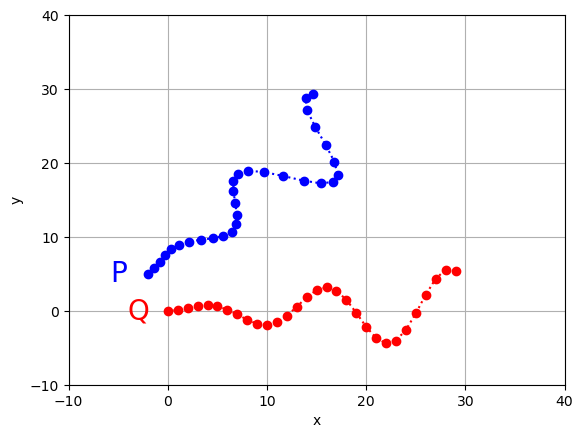

In [4]:
plot_data(P,Q)

**Find the correspondences**

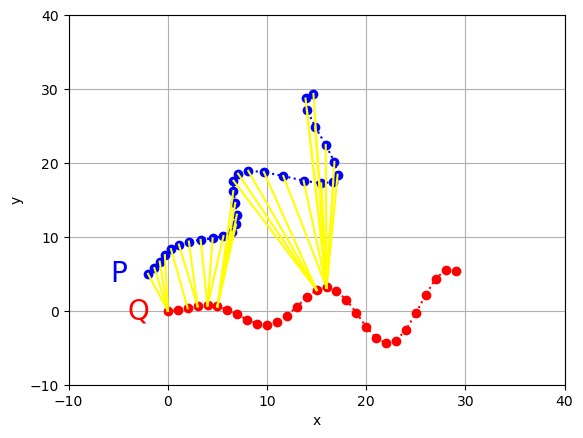

In [5]:
def correspondence(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

corr = correspondence(P,Q)
plot_data(P,Q)
for i, j in corr:
    x = [P[0, i], Q[0, j]]
    y = [P[1, i], Q[1, j]]
    plt.plot(x,y, color = "yellow")

In [6]:
# initial condition
X = np.array([1,1,np.deg2rad(25)])

def rotation(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def d_rotation(theta):
    return np.array([
        [-np.sin(theta), -np.cos(theta)],
        [np.cos(theta), -np.sin(theta)]
    ])

In [7]:
def jacobian(x, p):
    theta = x[2]
    J = np.zeros((2, 3))
    J[0:2, 0:2] = np.identity(2)
    J[0:2, [2]]= (d_rotation(theta)@p)
    return J

In [8]:
def error(x, p, q):
    R = rotation(x[2])
    t = x[0:2].reshape(2,1)
    return (R@p + t - q)

In [9]:
def solver(x, P, Q, correspondences):
    H = np.zeros((3,3))
    g = np.zeros((3,1))
    for i, j in correspondences:
        p = P[:, [i]]
        q = Q[:, [j]]
        e = error(x, p, q)
        J = jacobian(x, p)
        H += J.T @ J
        g += J.T @ e
    return H, g

In [21]:
def icp(P, Q, x_init, iteration, tolerance):
    x = x_init
    P_prev = P.copy()
    x_new = [x_init]
    P_new = [P.copy()]
    for i in range(iteration):
        R = rotation(x[2])
        t = x[0:2]
        corr = correspondence(P_prev, Q)
        H, g = solver(x, P, Q, corr)
        dx = -np.linalg.inv(H)@g.flatten()
        x = x + dx
        x[2] = np.arctan2(np.sin(x[2]), np.cos(x[2]))
        x_new.append(x)
        R = rotation(x[2])
        t = x[0:2].reshape(2, 1)
        P_prev = R @ P.copy() + t
        P_new.append(P_prev)
        if np.linalg.norm(dx) < tolerance:
            break
        
    return P_new

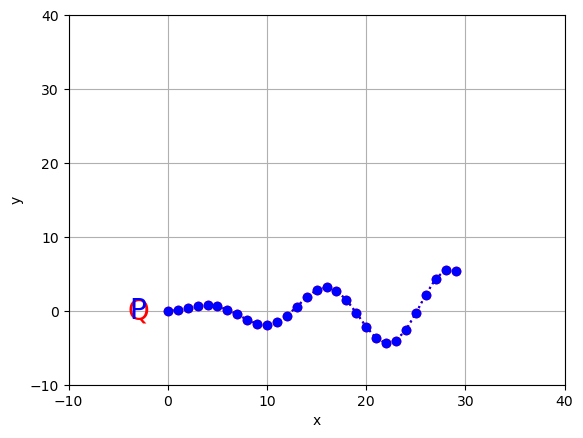

In [29]:
P_new = icp(P, Q, X, iteration = 100, tolerance = 1e-6)
plot_data(P_new[-1], Q)